In [1]:
%matplotlib inline
%run ../sparkutils.py

Using Spark version 1.6.0


# Linear regression modeling

We will use Spark linear regression to produce some predictions on voting patterns based on population statistics over the few years preceding the election. 

## The data

The data is coming from two sources, one is a census-derived dataset with health-related per-county statistics and the other is the vote percentages for Obama and Romney in the 2012 election.

First, load the data and infer the schema using our loadDF utility function.

In [2]:
health = loadDF('../data/2011_health.csv')
health.show(n=5)
elect = loadDF('../data/US_elect_county.csv')
elect.show(n=5)

+----+-------+-------+----------+----+-----------+----------------+------+-----+---------+-------+-------------------+---------------------------+-----------------------+--------------------+------------+------------------+-------------+
|FIPS|  State| County|Population|< 18|65 and over|African American|Female|Rural|%Diabetes|HIVrate|Physical Inactivity|mental health provider rate|median household income|% high housing costs|% Free lunch|% child Illiteracy|% Drive Alone|
+----+-------+-------+----------+----+-----------+----------------+------+-----+---------+-------+-------------------+---------------------------+-----------------------+--------------------+------------+------------------+-------------+
|1001|Alabama|Autauga|     50756|27.8|       11.6|            18.4|  51.4| 44.8|       11|    170|                 33|                          2|                  51622|                  25|          29|              12.7|           86|
|1003|Alabama|Baldwin|    179878|23.1|       17.

Next, we combine the datasets to create a single data frame based on the unique county identifier FIPS.

In [3]:
df = health.join(elect.drop('CountyName'), 'FIPS', 'inner')
df.show(n=5)

+-----+----------+---------+----------+----+-----------+----------------+------+-----+---------+-------+-------------------+---------------------------+-----------------------+--------------------+------------+------------------+-------------+-----------+----------+-------+-----------+--------+
| FIPS|     State|   County|Population|< 18|65 and over|African American|Female|Rural|%Diabetes|HIVrate|Physical Inactivity|mental health provider rate|median household income|% high housing costs|% Free lunch|% child Illiteracy|% Drive Alone|StatePostal|ObamaVotes|Obama %|RomneyVotes|Romney %|
+-----+----------+---------+----------+----+-----------+----------------+------+-----+---------+-------+-------------------+---------------------------+-----------------------+--------------------+------------+------------------+-------------+-----------+----------+-------+-----------+--------+
| 1031|   Alabama|   Coffee|     48635|24.0|       14.3|            17.9|  51.4| 55.9|       12|    121|        

In [4]:
df.schema

StructType(List(StructField(FIPS,IntegerType,true),StructField(State,StringType,true),StructField(County,StringType,true),StructField(Population,IntegerType,true),StructField(< 18,DoubleType,true),StructField(65 and over,DoubleType,true),StructField(African American,DoubleType,true),StructField(Female,DoubleType,true),StructField(Rural,DoubleType,true),StructField(%Diabetes,IntegerType,true),StructField(HIVrate,IntegerType,true),StructField(Physical Inactivity,IntegerType,true),StructField(mental health provider rate,IntegerType,true),StructField(median household income,IntegerType,true),StructField(% high housing costs,IntegerType,true),StructField(% Free lunch,IntegerType,true),StructField(% child Illiteracy,DoubleType,true),StructField(% Drive Alone,IntegerType,true),StructField(StatePostal,StringType,true),StructField(ObamaVotes,IntegerType,true),StructField(Obama %,StringType,true),StructField(RomneyVotes,IntegerType,true),StructField(Romney %,StringType,true)))

Ooops, "Obama %" and "Romney %" are strings, let's convert them to numerical values.

In [5]:
# Cast to double
df = df.withColumn('ObamaPercent',df["Obama %"].cast(DoubleType())).drop("Obama %")
df = df.withColumn('RomneyPercent',df["Romney %"].cast(DoubleType())).drop("Romney %")
df.show(n=5)

+-----+----------+---------+----------+----+-----------+----------------+------+-----+---------+-------+-------------------+---------------------------+-----------------------+--------------------+------------+------------------+-------------+-----------+----------+-----------+------------+-------------+
| FIPS|     State|   County|Population|< 18|65 and over|African American|Female|Rural|%Diabetes|HIVrate|Physical Inactivity|mental health provider rate|median household income|% high housing costs|% Free lunch|% child Illiteracy|% Drive Alone|StatePostal|ObamaVotes|RomneyVotes|ObamaPercent|RomneyPercent|
+-----+----------+---------+----------+----+-----------+----------------+------+-----+---------+-------+-------------------+---------------------------+-----------------------+--------------------+------------+------------------+-------------+-----------+----------+-----------+------------+-------------+
| 1031|   Alabama|   Coffee|     48635|24.0|       14.3|            17.9|  51.4| 5

In [6]:
print("Number of rows:", df.count())
print("Number of rows without missing values:", df.dropna().count())

Number of rows: 4025
Number of rows without missing values: 2926


In [7]:
df.select("HIVrate").show(10)
df = df.drop('HIVrate')
df.cache()

+-------+
|HIVrate|
+-------+
|    121|
|    159|
|    152|
|   null|
|    530|
|     40|
|   null|
|   null|
|   null|
|     35|
+-------+
only showing top 10 rows



DataFrame[FIPS: int, State: string, County: string, Population: int, < 18: double, 65 and over: double, African American: double, Female: double, Rural: double, %Diabetes: int, Physical Inactivity: int, mental health provider rate: int, median household income: int, % high housing costs: int, % Free lunch: int, % child Illiteracy: double, % Drive Alone: int, StatePostal: string, ObamaVotes: int, RomneyVotes: int, ObamaPercent: double, RomneyPercent: double]

## Some visualizations

First, let's visualize the data in order to identify potential candidates for the independent variables.

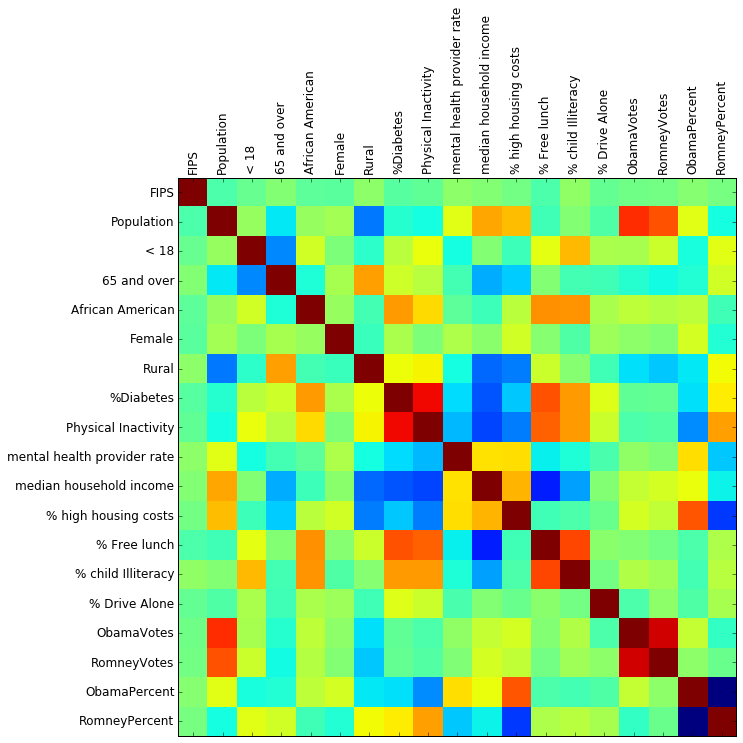

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':12})

def plot_corr(pandas_df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = pandas_df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);
    
pandasdf = df.toPandas()   # all on driver
plot_corr(pandasdf)

In [9]:
df.corr('% high housing costs','ObamaPercent')

0.6353177616043263

In [10]:
df.corr('% high housing costs','RomneyPercent')

-0.630377750248996

In [11]:
df.corr('Physical Inactivity','RomneyPercent')

0.47974546702904214

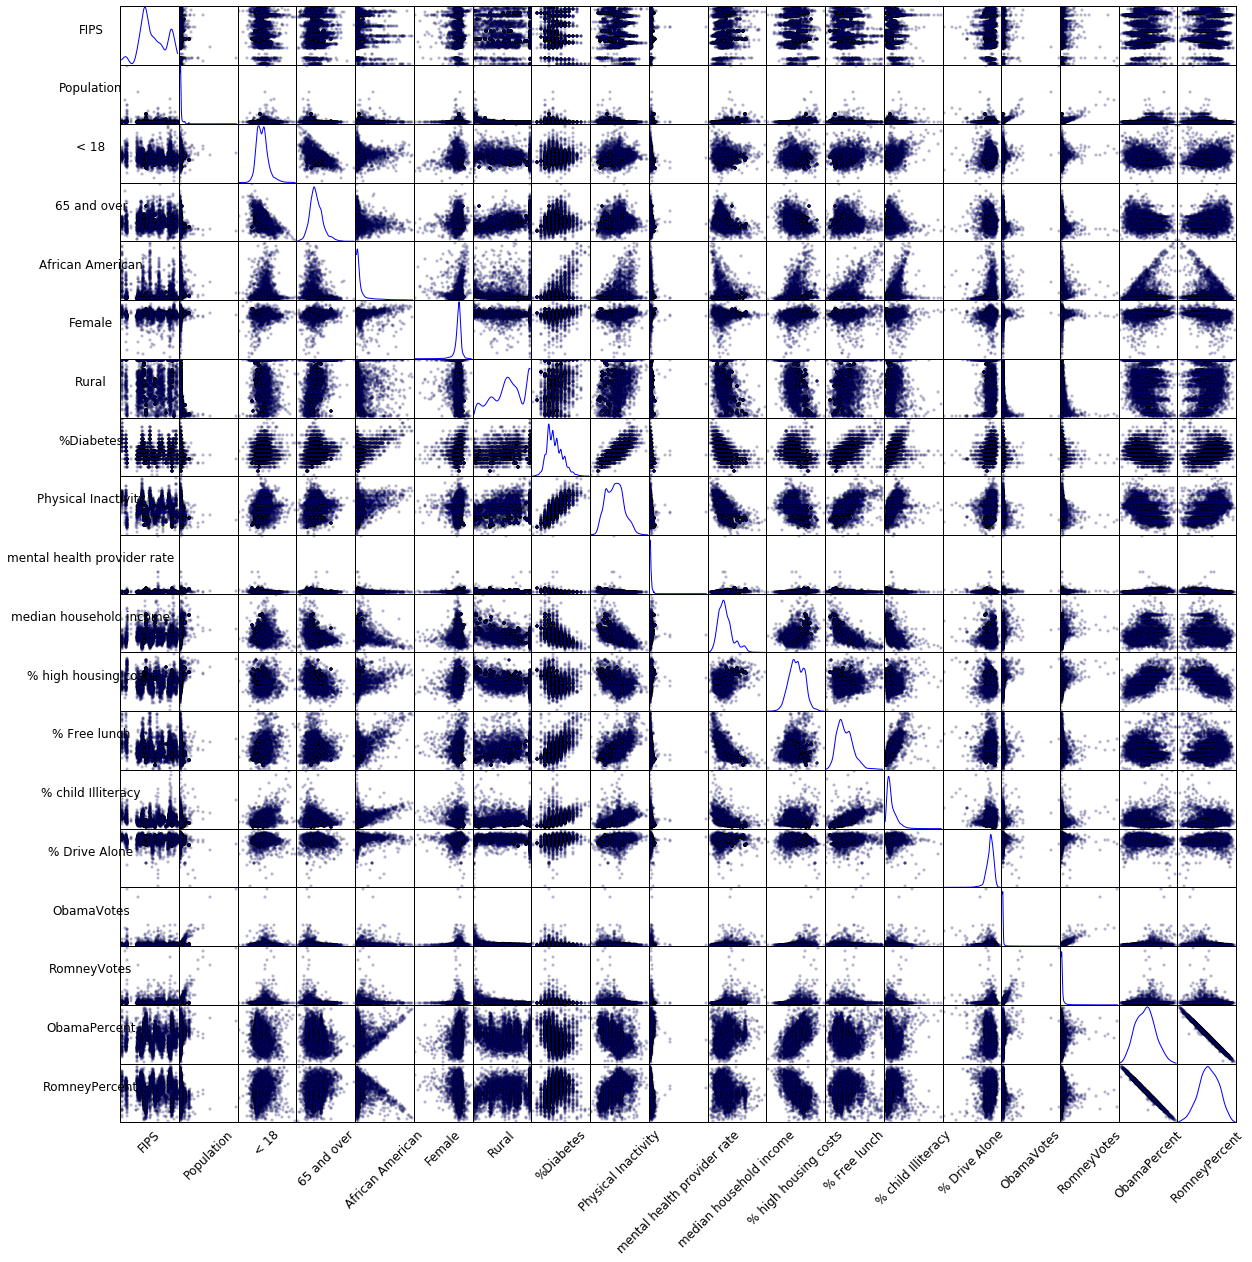

In [12]:
from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(pandasdf, alpha=0.2, figsize=(20, 20), diagonal='kde')
#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()
plt.savefig(r"scatter.png")

## Linear regression in Spark MLlib

In [76]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import DenseVector

df.head()

Row(FIPS=1031, State='Alabama', County='Coffee', Population=48635, < 18=24.0, 65 and over=14.3, African American=17.9, Female=51.4, Rural=55.9, %Diabetes=12, Physical Inactivity=30, mental health provider rate=2, median household income=43145, % high housing costs=25, % Free lunch=36, % child Illiteracy=13.4, % Drive Alone=84, StatePostal='AL', ObamaVotes=4899, RomneyVotes=14638, ObamaPercent=24.8, RomneyPercent=74.2)

In [77]:
# Prepare the data (LabeledPoint takes the label as the first arg)
from pyspark.mllib.regression import LabeledPoint

def convertRow(values):
    return LabeledPoint(float(values[0] or 0),
                        DenseVector([float(x or 0) for x in values[1:]]))

dataObama = df.select('ObamaPercent', '% high housing costs').map(convertRow).cache()
dataObama.take(5)

[LabeledPoint(24.8, [25.0]),
 LabeledPoint(33.2, [29.0]),
 LabeledPoint(40.8, [40.0]),
 LabeledPoint(13.0, [25.0]),
 LabeledPoint(74.0, [44.0])]

In [78]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Build the model, this can take a long time
modelObama = LinearRegressionWithSGD.train(dataObama)

In [79]:
# Predict voting percentages using model
valuesAndPreds = dataObama.map(lambda p: (float(modelObama.predict(p.features)), p.label))

In [74]:
from pyspark.mllib.evaluation import RegressionMetrics

# Evaluate the model on training data
# Instantiate metrics object
metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)

MSE = inf
RMSE = inf
R-squared = -inf
MAE = 4.480628598213472e+221
Explained variance = inf


Now do the same for Romney

In [ ]:
dataRomney = df.select('RomneyPercent', '% high housing costs').map(convertRow).cache()

# Build the model, this can take a long time
modelRomney = LinearRegressionWithSGD.train(dataRomney)

# Predict voting percentages using model
valuesAndPreds2 = dataRomney.map(lambda p: (float(modelRomney.predict(p.features)), p.label))

# Build the model, this can take a long time
modelRomney = LinearRegressionWithSGD.train(dataRomney)

# Evaluate the model on training data
# Instantiate metrics object
metrics2 = RegressionMetrics(valuesAndPreds2)

# Squared Error
print("MSE = %s" % metrics2.meanSquaredError)
print("RMSE = %s" % metrics2.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics2.r2)

# Mean absolute error
print("MAE = %s" % metrics2.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics2.explainedVariance)

In [ ]:
## Miscellaneous...
# Average population per county (not used here)
from pyspark.sql import functions as F
nationalAvg = float(get_stats_dict(df,'Population')['mean'])
avgHIVrates = df.groupby('State').agg(F.avg('Population').alias('avgPopulation')).na.fill(nationalAvg)
avgHIVrates.show(n=50)